In [62]:
import ee
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geemap.foliumap as geemap
import sys
import folium
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
import seaborn as sns

sys.path.append('../../')

from src.data.ee_utils import *
from src.data.data_utils import *

ee.Authenticate()
ee.Initialize()

In [3]:
lucas_points = ee.FeatureCollection("projects/ee-ayang115t/assets/lucas_2018_filtered_polygons")
lucas_points = ee.data.computeFeatures({
    'expression': lucas_points,
    'fileFormat': 'PANDAS_DATAFRAME'
})

In [5]:
lucas_labels = pd.read_csv('lucas_cover_attr.csv')
lucas_labels = lucas_labels.loc[lucas_labels['point_id'].isin(lucas_points['POINT_ID'])]

c:\Users\adamf\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (6,13,28,30,31,33,34,35,38,39,40,41,43,44,45,47,50,51,52,54,55,56,57,58,67,68,69,70,71,81,83,88,89,93,95,97,99,101,102,103,109,119) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
points = lucas_points.merge(lucas_labels, left_on='POINT_ID', right_on='point_id')
points = points.loc[:, ['POINT_ID', 'nuts0', 'lc1', 'geo', 'th_long', 'th_lat']]
points = points.loc[points['lc1'].str.contains('B')]

In [159]:
LUCAS2018_LEVEL1_CODES = {
    '1': 'Cereals',
    '2': 'Root crops',
    '3': 'Non permanent industrial crops',
    '4': 'Dry pulses, vegetables and flowers',
    '5': 'Fodder crops',
    '7': 'Permanent crops: fruits trees',
    '8': 'Other permanent crops',
    'X': 'X'
}

crop_classes = [LUCAS2018_LEVEL1_CODES[x[1]] for x in points['lc1']]
points['crop_class'] = crop_classes
points = points.loc[points['crop_class'] != 'X']
cmap = sns.color_palette('tab10', len(np.unique(points['crop_class'])))
colors = {label: cmap[i] for i, label in enumerate(points['crop_class'].unique())}


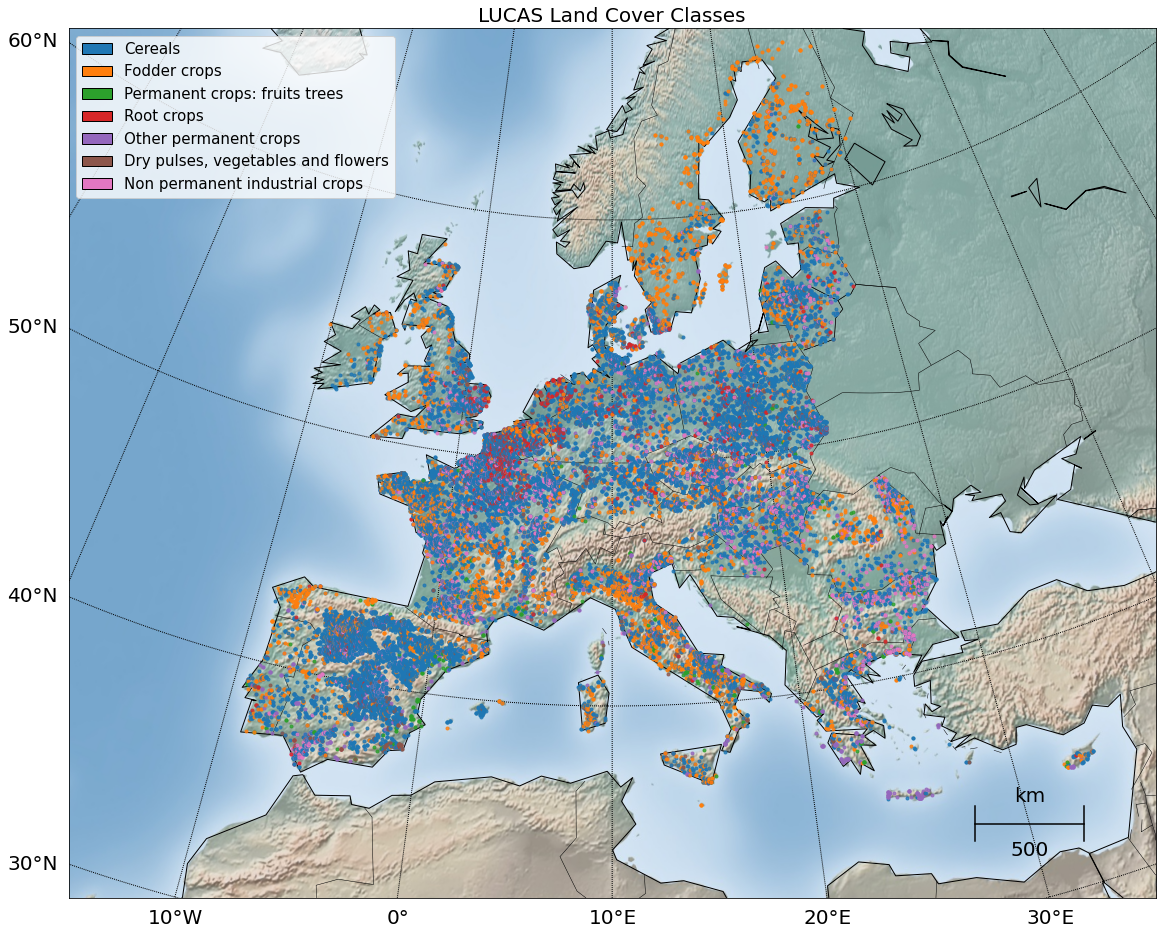

In [160]:
# Create a new figure for Basemap
plt.figure(figsize=(20, 16))

# Initialize the Basemap for Europe
m = Basemap(projection='lcc', resolution='c', lat_0=50, lon_0=10, width=5E6, height=4E6)
m.drawcountries()
m.drawcoastlines()
m.shadedrelief()

# Draw latitude and longitude lines
m.drawparallels(np.arange(-80., 81., 10.), labels=[True, False, False, False], fontsize=20)
m.drawmeridians(np.arange(-180., 181., 10.), labels=[False, False, False, True], fontsize=20)

# Add scale bar at the lower right
# You may need to adjust these values to fit the scale bar within your map
scale_lon = 30  # Adjust this to move the scale bar left or right
scale_lat = 33  # Adjust this to move the scale bar up or down
m.drawmapscale(lon=scale_lon, lat=scale_lat, lon0=10, lat0=50, length=500, barstyle='simple', units='km', fontsize=20)

# Loop through the DataFrame and plot each PFT with its respective color and shape
for index, row in points.iterrows():
    x, y = m(row['th_long'], row['th_lat'])
    plt.plot(x, y, marker='o',color=colors[row['crop_class']], markersize=3, alpha=0.8)
    
legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=crop) for crop in colors.keys()]

# Add the legend to the plot
plt.legend(handles=legend_elements, loc='upper left', fontsize=15)
plt.title('LUCAS Land Cover Classes', fontsize=20)
# Display the plot
plt.show()
# plt.savefig('./LUCAS_plot.png')

No handles with labels found to put in legend.


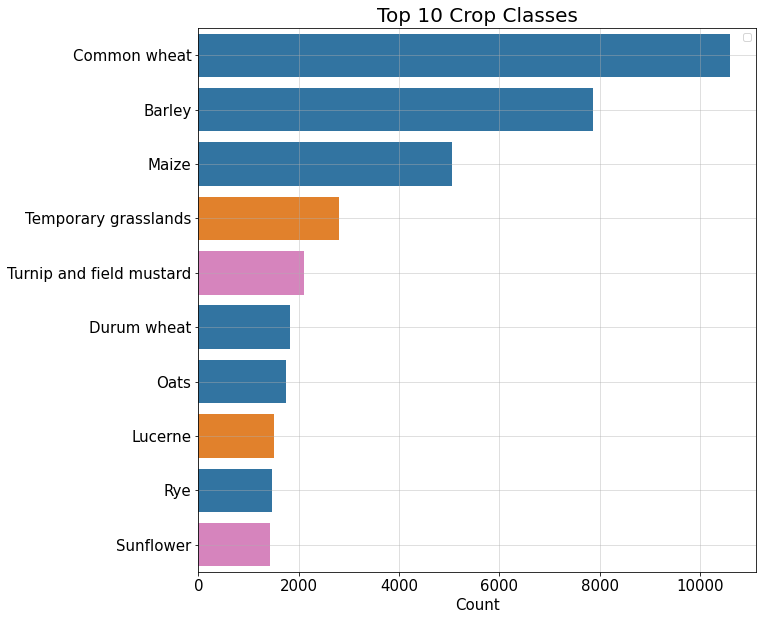

In [161]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

LUCAS2018_LEVEL2_CODES = {
    'B11': 'Common wheat',
    'B12': 'Durum wheat',
    'B13': 'Barley',
    'B14': 'Rye',
    'B15': 'Oats',
    'B16': 'Maize',
    'B17': 'Rice',
    'B18': 'Triticale',
    'B19': 'Other cereals',
    'B21': 'Potatoes',
    'B22': 'Sugar beet',
    'B23': 'Other root crops',
    'B31': 'Sunflower',
    'B32': 'Turnip and field mustard',
    'B33': 'Soya',
    'B34': 'Cotton',
    'B35': 'Other fibre and oleaginous crops',
    'B36': 'Tobacco',
    'B37': 'Other non-permanent industrial crops',
    'B41': 'Dry pulses',
    'B42': 'Tomatoes',
    'B43': 'Other fresh vegetables',
    'B44': 'Floricutural and ornamental plants',
    'B45': 'Strawberries',
    'B51': 'Clovers',
    'B52': 'Lucerne',
    'B53': 'Other leguminous and mixtures for fodder',
    'B54': 'Mixed cereals for fodder',
    'B55': 'Temporary grasslands',
    'B71': 'Apple fruit',
    'B72': 'Pear fruit',
    'B73': 'Cherry fruit',
    'B74': 'Nuts trees',
    'B75': 'Other fruit trees and berries',
    'B76': 'Oranges',
    'B77': 'Other citrus fruit',
    'B80': 'Olive groves',
    'B82': 'Vineyards',
    'B83': 'Nurseries',
    'B84': 'Permanent industrial crops'
}

plt.figure(figsize=(10, 10))

# Get the unique values and their counts
unique_values, counts = np.unique(points['lc1'], return_counts=True)
count_sort_ind = np.argsort(-counts)
unique_values, counts = unique_values[count_sort_ind][:10], counts[count_sort_ind][:10]
crop_colors = [colors[LUCAS2018_LEVEL1_CODES[x[1]]] for x in unique_values]

plt.title('Top 10 Crop Classes', fontsize=20)
# Create a bar plot
sns.barplot(y=unique_values, x=counts, orient='h', palette=crop_colors)

legend_elements = [Patch(facecolor=colors[crop], edgecolor='black',
                     label=crop) for crop in colors.keys()]

plt.yticks(range(len(unique_values)), [LUCAS2018_LEVEL2_CODES[x] for x in unique_values], fontsize=15)
plt.xticks(fontsize=15)
plt.grid(alpha=0.5)
plt.legend()
plt.xlabel('Count', fontsize=15)
plt.show()